## Here are some explanations relating to the numbered questions:

1. Our dataset is "StudentPerformanceFactors.csv". We chose 'Learning_Disabilities' as our binary categorical response variable. Its values are 'Yes' and 'No'

2. See code, we got the following results:
    Confusion Matrix:
    [[3525    1]
    [ 433    4]]

    Accuracy: 0.8904870047943477
    Prediction Error: 0.10951299520565227
    True Positive Rate (TPR): 0.009153318077803204
    True Negative Rate (TNR): 0.9997163925127623
    F1 Score: 0.01809954751131222

As you can see, a similar outcome to last week's Check-In occurred. Our model simply predicts almost everything to by Negative, and since the majority of the dataset is True Negatives, this ends up being a decent method. This is seen in the 99.9% TNR.

3. See code, we got the following results:
    AUC Scores for each fold: [0.48451198 0.6037405  0.66759988 0.55671313 0.60366838]
    Average AUC: 0.5832467748468251
    Accuracy Scores for each fold: [0.89056604 0.88301887 0.89393939 0.88257576 0.88636364]
    Average Accuracy: 0.8872927387078331

Again, these metrics are well-created, but the data used is misleading / not the best for creating examples. However, the accuracy measures across each fold hover around the 89% mark, which is decent.


In [22]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from scipy.stats import pointbiserialr

complete_data = pd.read_csv("StudentPerformanceFactors.csv")

In [23]:
## Similar to Check-In 3, I revisited this notebook to now use 7 predictor variables instead pf 1
main_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Parental_Involvement', 'Learning_Disabilities', 'Access_to_Resources', 'Tutoring_Sessions', 'Exam_Score']


# Exam_Score will be mapped as follows using the Passed_Exam variable:
    # If Exam_Score >= 60: Passed_Exam = 1
    # Else: Passed_Exam = 0

# Extract our main features
data = complete_data[main_features].copy()
pass_threshold = 70

# Encode Exam_Score using pass_threshold to new Passed_Exam column
data['Passed_Exam'] = (data['Exam_Score'] >= pass_threshold).astype(int)

## split data into predictors and target, Exam_Score column no longer needed for both
X = data.drop(['Exam_Score', 'Passed_Exam'], axis=1)
y = data['Passed_Exam']

print(X.head())
print(y.head())


## We need to One-Hot Encode 3 of our predictor features:
    # Parental_Involvement [Low, Medium, High]
    # Learning_Disability  [No, Yes]
    # Access_to_Resources  [Low, Medium, High]

categorical_features = ['Parental_Involvement', 'Access_to_Resources', 'Learning_Disabilities']
# this drops one category from each feature to create a baseline, which helps avoid perfect collinear variables
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(X_encoded.head())

   Hours_Studied  Attendance  Previous_Scores Parental_Involvement  \
0             23          84               73                  Low   
1             19          64               59                  Low   
2             24          98               91               Medium   
3             29          89               98                  Low   
4             19          92               65               Medium   

  Learning_Disabilities Access_to_Resources  Tutoring_Sessions  
0                    No                High                  0  
1                    No              Medium                  2  
2                    No              Medium                  2  
3                    No              Medium                  1  
4                    No              Medium                  3  
0    0
1    0
2    1
3    1
4    1
Name: Passed_Exam, dtype: int64
   Hours_Studied  Attendance  Previous_Scores  Tutoring_Sessions  \
0             23          84               73         

Random Forest Test Set Evaluation:
Accuracy: 0.91
Prediction Error: 0.09
True Positive Rate (TPR): 0.76
True Negative Rate (TNR): 0.97


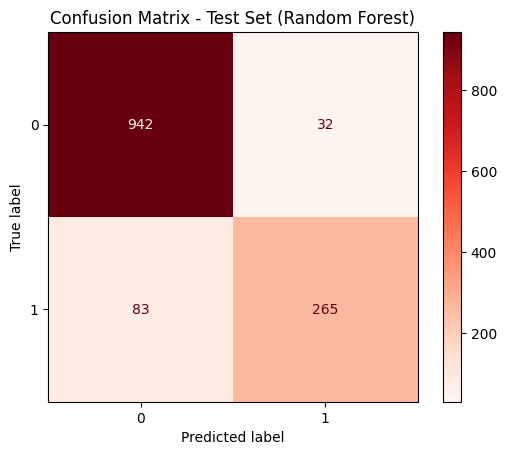

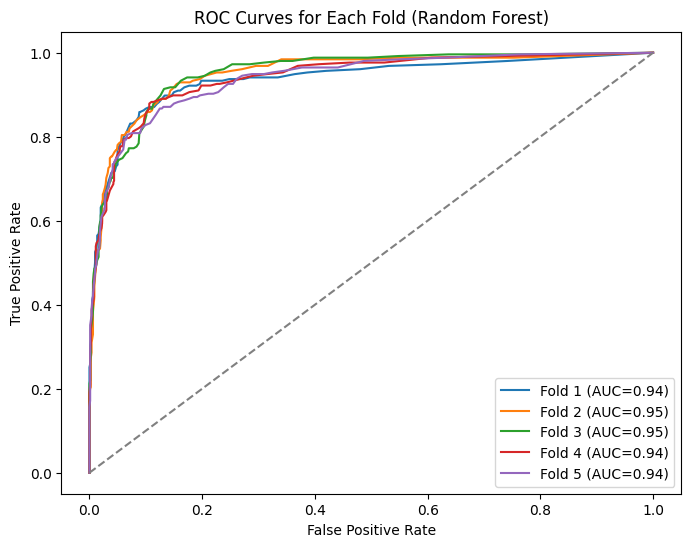

Cross-Validation Results (Random Forest):
Average AUC: 0.94
Average Accuracy: 0.90


'\n#putting column name in a variable for now cuz idk which were using\npredictor_variable = "Exam_Score"\nresponse_variable = \'Learning_Disabilities\'\nmain_features = [response_variable, predictor_variable]\ndata = complete_data[main_features]\n\n# making the response variable have a binary encoding\ndata[response_variable] = data[response_variable].map({\'No\': 0, \'Yes\': 1})\n\n# Check to see if data cleaning needed\nnans_response = data[response_variable].isnull().sum()\nprint(f"NaNs in {response_variable}: {nans_response}")\n\nnans_predictor = data[predictor_variable].isnull().sum()\nprint(f"NaNs in {predictor_variable}: {nans_predictor}")\n\ninfs_response = np.isinf(data[response_variable]).sum()\nprint(f"Infs in {response_variable}: {infs_response}")\n\ninfs_predictor = np.isinf(data[predictor_variable]).sum()\nprint(f"Infs in {predictor_variable}: {infs_predictor}")\n'

In [24]:

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# standardization
numeric_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions']
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

# evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
prediction_error = 1 - accuracy
true_positive_rate = recall_score(y_test, y_pred)
true_negative_rate = recall_score(y_test, y_pred, pos_label=0)

print("Random Forest Test Set Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Prediction Error: {prediction_error:.2f}")
print(f"True Positive Rate (TPR): {true_positive_rate:.2f}")
print(f"True Negative Rate (TNR): {true_negative_rate:.2f}")

# make the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix - Test Set (Random Forest)")
plt.show()

## 5 fold Cross validation with RF
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
acc_scores = []

plt.figure(figsize=(8,6))
for i, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train), 1):
    X_train_fold, X_val_fold = X_train_scaled.iloc[train_index], X_train_scaled.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    fold_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    fold_rf_model.fit(X_train_fold, y_train_fold)
    
    y_val_pred_proba = fold_rf_model.predict_proba(X_val_fold)[:, 1]
    y_val_pred = fold_rf_model.predict(X_val_fold)
    
    fold_auc = roc_auc_score(y_val_fold, y_val_pred_proba)
    fold_acc = accuracy_score(y_val_fold, y_val_pred)
    auc_scores.append(fold_auc)
    acc_scores.append(fold_acc)
    
    fpr, tpr, _ = roc_curve(y_val_fold, y_val_pred_proba)
    plt.plot(fpr, tpr, label=f"Fold {i} (AUC={fold_auc:.2f})")

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Fold (Random Forest)")
plt.legend(loc="lower right")
plt.show()

print("Cross-Validation Results (Random Forest):")
print(f"Average AUC: {np.mean(auc_scores):.2f}")
print(f"Average Accuracy: {np.mean(acc_scores):.2f}")




'''
#putting column name in a variable for now cuz idk which were using
predictor_variable = "Exam_Score"
response_variable = 'Learning_Disabilities'
main_features = [response_variable, predictor_variable]
data = complete_data[main_features]

# making the response variable have a binary encoding
data[response_variable] = data[response_variable].map({'No': 0, 'Yes': 1})

# Check to see if data cleaning needed
nans_response = data[response_variable].isnull().sum()
print(f"NaNs in {response_variable}: {nans_response}")

nans_predictor = data[predictor_variable].isnull().sum()
print(f"NaNs in {predictor_variable}: {nans_predictor}")

infs_response = np.isinf(data[response_variable]).sum()
print(f"Infs in {response_variable}: {infs_response}")

infs_predictor = np.isinf(data[predictor_variable]).sum()
print(f"Infs in {predictor_variable}: {infs_predictor}")
'''

In [25]:
# using the same code from the previous check-in, we'll split the data into training, validation, and test sets
# Next, divide the new dataframe into 3 different data sets using a 60:20:20 split
# We chose 60:20:20 as opposed to 80:10:10 or somwhere in between to decrease the likelihood of overfitting, since the metrics used are potentially subseptible to overfitting


train_and_validation_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

train_df, validation_df = train_test_split(train_and_validation_df, test_size=0.25, random_state=42)

train_df.to_csv('Student_Performance_train.csv', index=False)
validation_df.to_csv('Student_Performance_validation.csv', index=False)
test_df.to_csv('Student_Performance_test.csv', index=False)

In [26]:
## calculate correlation between our two variables using the testing set

corr_coef, _ = pointbiserialr(train_df[response_variable], train_df[predictor_variable])

print("Train Correlation:", corr_coef)

## calculate correlation between our two variables using the validation set

corr_coef, _ = pointbiserialr(validation_df[response_variable], validation_df[predictor_variable])

print("Validation Correlation:", corr_coef)

## calculate correlation between our two variables using the test set

corr_coef, _ = pointbiserialr(test_df[response_variable], test_df[predictor_variable])

print("Test Correlation:", corr_coef)

NameError: name 'response_variable' is not defined

In [ ]:

x_train = train_df[[predictor_variable]]
y_train = train_df[response_variable]

# Training the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# Making predictions
y_pred = rf_model.predict(x_train)

# Calculating the confusion matrix and other metrics
c_m = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(c_m)

accuracy = accuracy_score(y_train, y_pred)
prediction_error = 1 - accuracy
true_positive_rate = recall_score(y_train, y_pred)  # TPR
true_negative_rate = recall_score(y_train, y_pred, pos_label=0)  # TNR
f1 = f1_score(y_train, y_pred)  # F1 Score

print(f"\nAccuracy: {accuracy}")
print(f"Prediction Error: {prediction_error}")
print(f"True Positive Rate (TPR): {true_positive_rate}")
print(f"True Negative Rate (TNR): {true_negative_rate}")
print(f"F1 Score: {f1}")

# 5-fold cross-validation on validation set
X_val = validation_df[[predictor_variable]]
y_val = validation_df[response_variable]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate AUC, accuracy and F1 across the folds
auc_scores = cross_val_score(rf_model, X_val, y_val, cv=cv, scoring='roc_auc')
accuracy_scores = cross_val_score(rf_model, X_val, y_val, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(rf_model, X_val, y_val, cv=cv, scoring='f1')

print("\nAUC Scores for each fold:", auc_scores)
print("Average AUC:", np.mean(auc_scores))
print("Accuracy Scores for each fold:", accuracy_scores)
print("Average Accuracy:", np.mean(accuracy_scores))
print("F1 Scores for each fold:", f1_scores)
print("Average F1:", np.mean(f1_scores))

# Plot AUC curve
rf_model.fit(X_val, y_val)  # Fit model to validation data for ROC curve plotting
y_val_proba = rf_model.predict_proba(X_val)[:, 1]  # Probability of the positive class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
auc = roc_auc_score(y_val, y_val_proba)

fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC = {auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random'))

fig.update_layout(
    title="Random Forest ROC Curve on Validation Set",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    showlegend=True
)

fig.show()


Confusion Matrix:
[[3525    1]
 [ 433    4]]

Accuracy: 0.8904870047943477
Prediction Error: 0.10951299520565227
True Positive Rate (TPR): 0.009153318077803204
True Negative Rate (TNR): 0.9997163925127623
F1 Score: 0.01809954751131222

AUC Scores for each fold: [0.48451198 0.6037405  0.66759988 0.55671313 0.60366838]
Average AUC: 0.5832467748468251
Accuracy Scores for each fold: [0.89056604 0.88301887 0.89393939 0.88257576 0.88636364]
Average Accuracy: 0.8872927387078331
F1 Scores for each fold: [0. 0. 0. 0. 0.]
Average F1: 0.0
